In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import operator
import folium
from ggplot import *

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from neupy import algorithms, estimators, environment, layers, plots, init
from xgboost import XGBClassifier
from xgboost import plot_importance

from RBFN import RBFN
from ensemble import AveragedNetwork, StackedNetwork

sns.set(style="whitegrid")

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load & Merge Data [Note: raw datafiles are stored in /Data]

In [2]:
properties = pd.read_csv('Data/properties_2016.csv', header=0, encoding='utf-8')
train = pd.read_csv('Data/train_2016_v2.csv', parse_dates=["transactiondate"], header=0, encoding='utf-8')

merged_df = pd.merge(train,properties,on="parcelid",how="left")

print("Shape Of Dataset: ", merged_df.shape)

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape Of Dataset:  (90275, 60)


### Save Merged Data

In [3]:
merged_df.to_csv("Data/merged_2016.csv", index=False)

# Data Understanding

## Load Data

In [4]:
merged_df = pd.read_csv("Data/merged_2016.csv")

## Describe Data

In [5]:
merged_df.describe().to_csv("data_desc.csv")
merged_df.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,9.027500e+04,90275.000000,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,...,95.000000,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783.000000,8.967000e+04
mean,1.298466e+07,0.011457,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,...,311.694737,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,13.402692,6.049151e+13
std,2.504510e+06,0.161079,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,...,346.354850,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.715966,2.046605e+11
min,1.071174e+07,-4.605000,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,...,18.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.000000,6.037101e+13
25%,1.155950e+07,-0.025300,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,...,100.000000,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,13.000000,6.037320e+13
50%,1.254734e+07,0.006000,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,...,159.000000,1970.000000,1.000000,1.320000e+05,3.428720e+05,2015.0,1.929700e+05,4542.750000,14.000000,6.037615e+13
75%,1.422755e+07,0.039200,1.000000,7.000000,872.000000,3.000000,4.000000,4.0,7.000000,3.000000,...,361.000000,1987.000000,2.000000,2.105345e+05,5.405890e+05,2015.0,3.454195e+05,6901.090000,15.000000,6.059042e+13
max,1.629608e+08,4.737000,13.000000,21.000000,1555.000000,20.000000,16.000000,4.0,12.000000,20.000000,...,1366.000000,2015.000000,4.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,99.000000,6.111009e+13


### Display Features Data Type

In [6]:
pd.options.display.max_rows = 65

dtype_df = merged_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,object
3,airconditioningtypeid,float64
4,architecturalstyletypeid,float64
5,basementsqft,float64
6,bathroomcnt,float64
7,bedroomcnt,float64
8,buildingclasstypeid,float64
9,buildingqualitytypeid,float64


### Show Frst Few Rows of Data

In [7]:
merged_df.head(3).transpose()

,0,1,2
parcelid,11016594,14366692,12098116
logerror,0.0276,-0.1684,-0.004
transactiondate,2016-01-01,2016-01-01,2016-01-01
airconditioningtypeid,1,NaN,1
architecturalstyletypeid,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,2,3.5,3
bedroomcnt,3,4,2
buildingclasstypeid,NaN,NaN,NaN
buildingqualitytypeid,4,NaN,4


## Geospatial Plot

In [8]:
n_clusters = round(merged_df.regionidzip.unique().shape[0] / 2)

print("number of clusters: {}".format(n_clusters))

number of clusters: 194


In [9]:
from sklearn.cluster import MiniBatchKMeans

geographical_df = merged_df.loc[:, ('latitude', 'longitude', 'logerror')]
geographical_df['longitude'] = geographical_df['longitude'] / 1000000
geographical_df['latitude'] = geographical_df['latitude'] / 1000000
geographical_df = geographical_df.dropna(subset=['latitude','longitude'], axis=0)

kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000).fit(geographical_df[['latitude','longitude']])
geographical_df.loc[:, 'label'] = kmeans.labels_

geo_map = folium.Map(location=[geographical_df['latitude'].mean(), geographical_df['longitude'].mean()], zoom_start=9)

for label in kmeans.cluster_centers_:
    location = [label[0], label[1]]
    folium.Marker(location=location).add_to(geo_map)

geo_map

## Univariate Analysis

### Plot Histogram of Target Class (logerror)

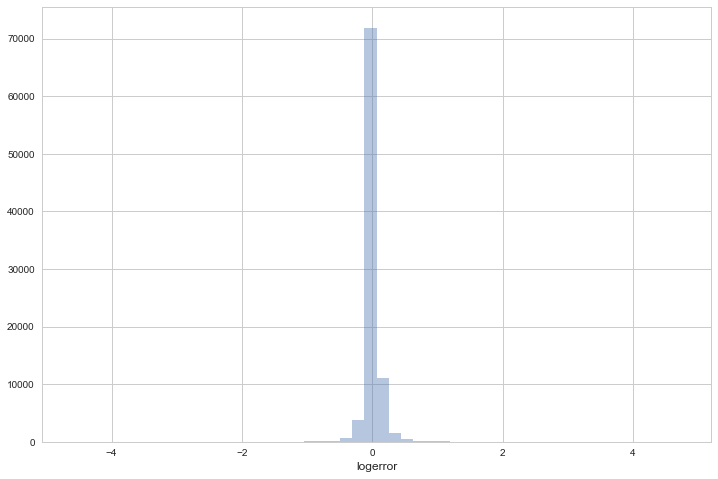

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(merged_df['logerror'], bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

### Plot Histogram of absolute logerror

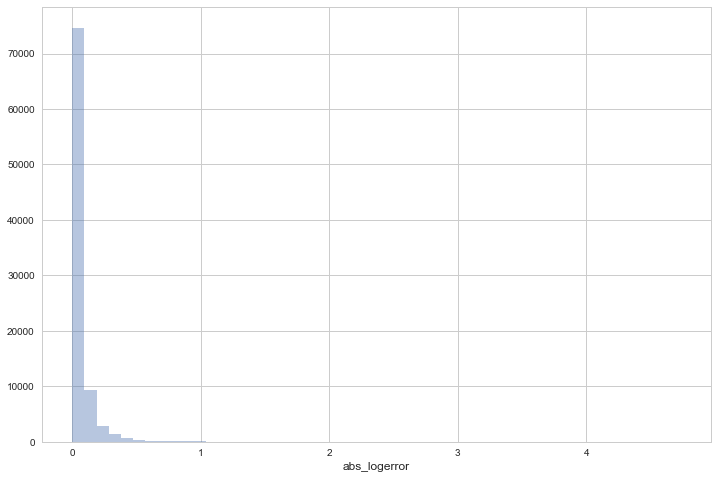

In [11]:
merged_df['abs_logerror'] = abs(merged_df['logerror'])

plt.figure(figsize=(12,8))
sns.distplot(merged_df['abs_logerror'], bins=50, kde=False)
plt.xlabel('abs_logerror', fontsize=12)
plt.show()

### Plot the target class (logerror of Zillow)

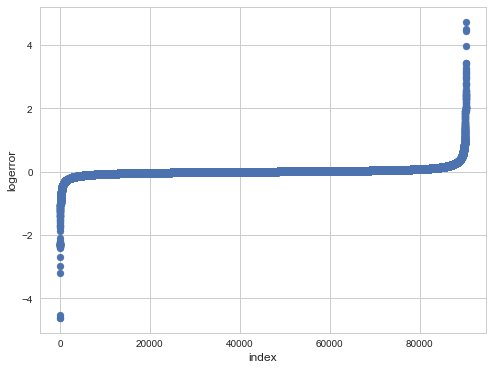

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(range(merged_df.shape[0]), np.sort(merged_df['logerror'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

This looks nice with some outliers at both the ends!

## Continuous Variable

### Histogram of Total Area (calculatedfinishedsquarefeet)

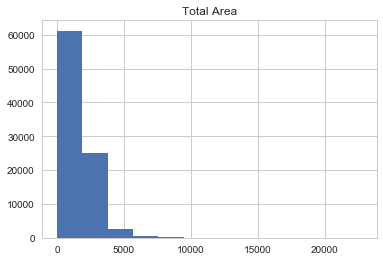

In [13]:
plt.hist(merged_df['calculatedfinishedsquarefeet'].dropna(), bins=12) 
plt.title("Total Area") 
plt.show()

## Categorial Variable

### Histogram of number of bathroom

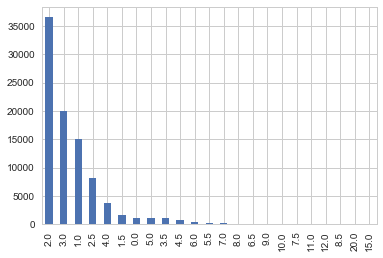

In [14]:
merged_df['bathroomcnt'].dropna().value_counts().plot(kind="bar")

### Histogram of number of bedroom

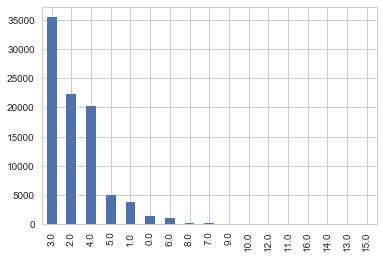

In [15]:
merged_df['bedroomcnt'].dropna().value_counts().plot(kind="bar")

### Histogram of number of unit

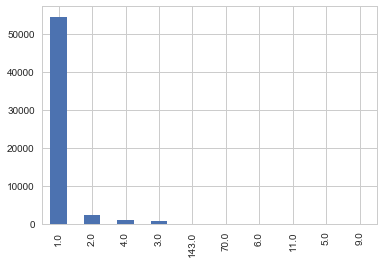

In [16]:
merged_df['unitcnt'].dropna().value_counts().plot(kind="bar")

## Bivariate Analysis

### Where does Zestimate predict well?
To get a quick feel where zestimate predicts well, we can group our absolute logerror into different percentiles, e.g. the percentile with best predictions (top 10%), worst predictions (worst 10%) and typical predictions (50% around the median).

In [17]:
best_fit_df = merged_df[merged_df['abs_logerror'] < merged_df.quantile(0.1)['abs_logerror']]
best_fit_df['type'] = 'best_fit'

average_fit_df = merged_df[merged_df['abs_logerror'] > merged_df.quantile(0.25)['abs_logerror']]
average_fit_df = average_fit_df[average_fit_df['abs_logerror'] < merged_df.quantile(0.75)['abs_logerror']]
average_fit_df['type'] = 'average_fit'

worst_fit_df = merged_df[merged_df['abs_logerror'] > merged_df.quantile(0.9)['abs_logerror']]
worst_fit_df['type'] = 'worst_fit'

percentile_df = pd.concat([best_fit_df, average_fit_df, worst_fit_df])

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Absolute logerror by latitude grouped by best, average, and worst fit

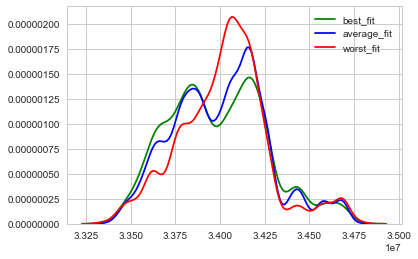

In [18]:
best_fit = best_fit_df['latitude'].rename("best_fit")
average_fit = average_fit_df['latitude'].rename("average_fit")
worst_fit = worst_fit_df['latitude'].rename("worst_fit")

ax=sns.kdeplot(best_fit, shade=False, color="g")
ax=sns.kdeplot(average_fit, shade=False, color="b")
ax=sns.kdeplot(worst_fit, shade=False, color="r")

### Absolute logerror by longitude grouped by best, average, and worst fit

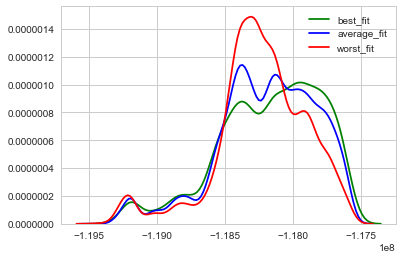

In [19]:
best_fit = best_fit_df['longitude'].rename("best_fit")
average_fit = average_fit_df['longitude'].rename("average_fit")
worst_fit = worst_fit_df['longitude'].rename("worst_fit")

ax=sns.kdeplot(best_fit, shade=False, color="g")
ax=sns.kdeplot(average_fit, shade=False, color="b")
ax=sns.kdeplot(worst_fit, shade=False, color="r")

### Absolute logerror by finishedsquarefeet15 (Total area) grouped by best, average, and worst fit

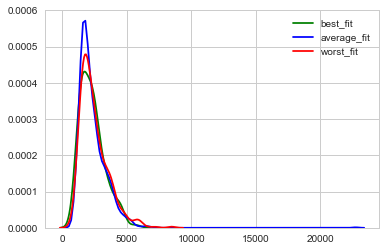

In [20]:
best_fit = best_fit_df['finishedsquarefeet15'].rename("best_fit")
average_fit = average_fit_df['finishedsquarefeet15'].rename("average_fit")
worst_fit = worst_fit_df['finishedsquarefeet15'].rename("worst_fit")

ax=sns.kdeplot(best_fit, shade=False, color="g")
ax=sns.kdeplot(average_fit, shade=False, color="b")
ax=sns.kdeplot(worst_fit, shade=False, color="r")

### Absolute logerror by yearbuilt (Built Year) grouped by best, average, and worst fit

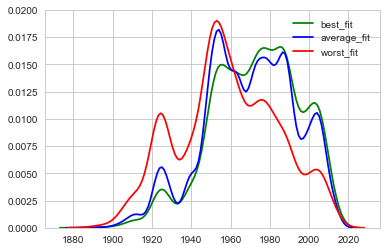

In [21]:
best_fit = best_fit_df['yearbuilt'].rename("best_fit")
average_fit = average_fit_df['yearbuilt'].rename("average_fit")
worst_fit = worst_fit_df['yearbuilt'].rename("worst_fit")

ax=sns.kdeplot(best_fit, shade=False, color="g")
ax=sns.kdeplot(average_fit, shade=False, color="b")
ax=sns.kdeplot(worst_fit, shade=False, color="r")

### Absolute logerror by finishedsquarefeet12 (Finished living area) grouped by best, average, and worst fit

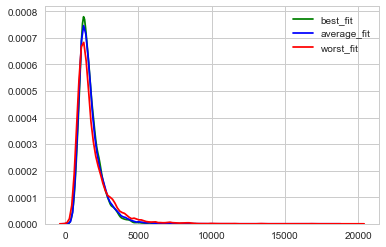

In [22]:
best_fit = best_fit_df['finishedsquarefeet12'].rename("best_fit")
average_fit = average_fit_df['finishedsquarefeet12'].rename("average_fit")
worst_fit = worst_fit_df['finishedsquarefeet12'].rename("worst_fit")

ax=sns.kdeplot(best_fit, shade=False, color="g")
ax=sns.kdeplot(average_fit, shade=False, color="b")
ax=sns.kdeplot(worst_fit, shade=False, color="r")

## Multivariate Analysis

### Compute the correlation matrix

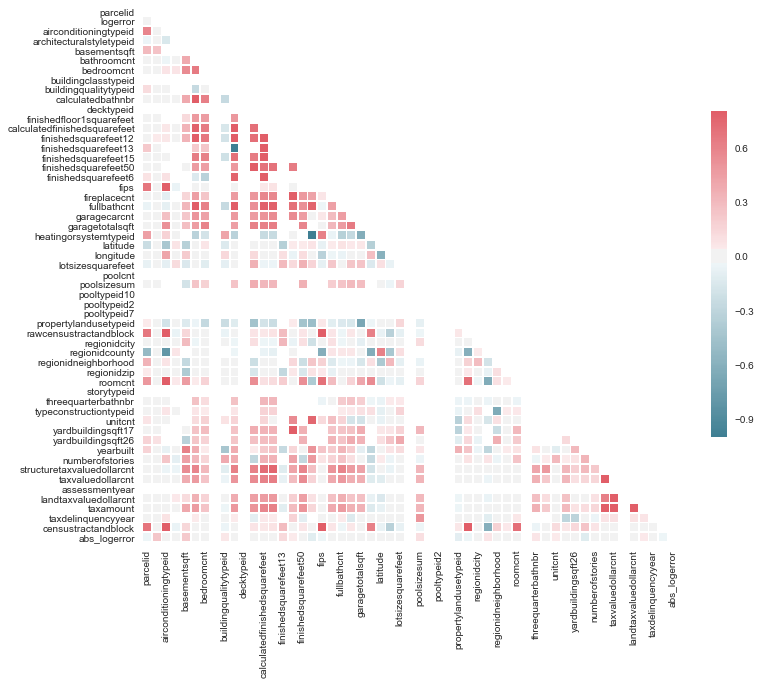

In [23]:
corr = merged_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})

# Data Preparation

## Clean Data

### Remove Outliers

Let us remove the outliers based on target class (logerror) and then do a histogram plot on the same.

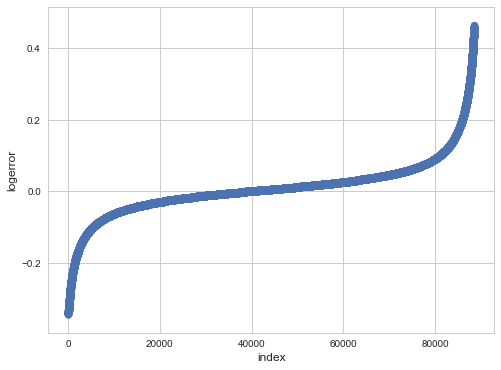

In [24]:
merged_df = merged_df[merged_df['logerror'] < merged_df['logerror'].quantile(.99)]
merged_df = merged_df[merged_df['logerror'] > merged_df['logerror'].quantile(.01)]

plt.figure(figsize=(8,6))
plt.scatter(range(merged_df.shape[0]), np.sort(merged_df['logerror']))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

#### Plot Histogram of Target Class (logerror) again

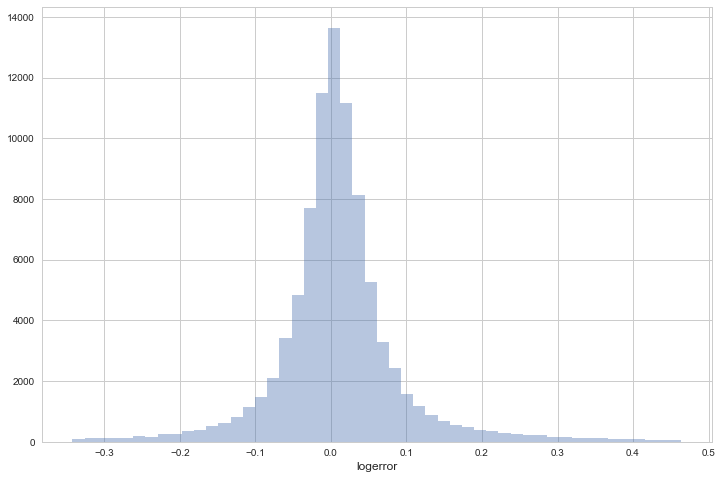

In [25]:
plt.figure(figsize=(12,8))
sns.distplot(merged_df['logerror'], bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

#### Plot Histogram of absolute logerror again

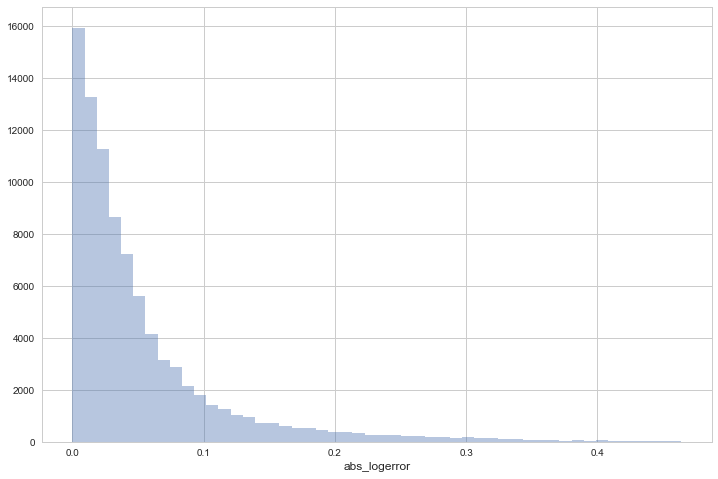

In [26]:
merged_df['abs_logerror'] = abs(merged_df['logerror'])

plt.figure(figsize=(12,8))
sns.distplot(merged_df['abs_logerror'], bins=50, kde=False)
plt.xlabel('abs_logerror', fontsize=12)
plt.show()

#### Remove Outlier based on Total Area

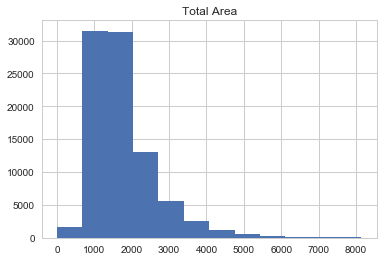

In [27]:
merged_df = merged_df[merged_df['calculatedfinishedsquarefeet'] < merged_df['calculatedfinishedsquarefeet'].quantile(.999)]

plt.hist(merged_df['calculatedfinishedsquarefeet'].dropna(), bins=12) 
plt.title("Total Area") 
plt.show()

#### Remove Outlier based on number of bathroom

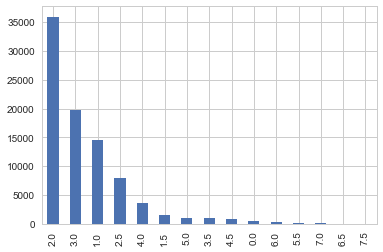

In [28]:
merged_df = merged_df[merged_df['bathroomcnt'] < merged_df['bathroomcnt'].quantile(.999)]

merged_df['bathroomcnt'].dropna().value_counts().plot(kind="bar")

#### Remove Outlier based on number of bedroom

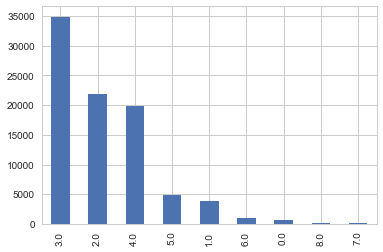

In [29]:
merged_df = merged_df[merged_df['bedroomcnt'] < merged_df['bedroomcnt'].quantile(.999)]

merged_df['bedroomcnt'].dropna().value_counts().plot(kind="bar")

#### Remove Outlier based on number of unit

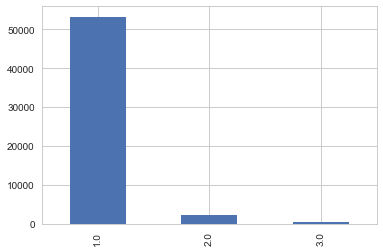

In [30]:
merged_df = merged_df[merged_df['unitcnt'] < merged_df['unitcnt'].quantile(.999)]

merged_df['unitcnt'].dropna().value_counts().plot(kind="bar")

### Missing values

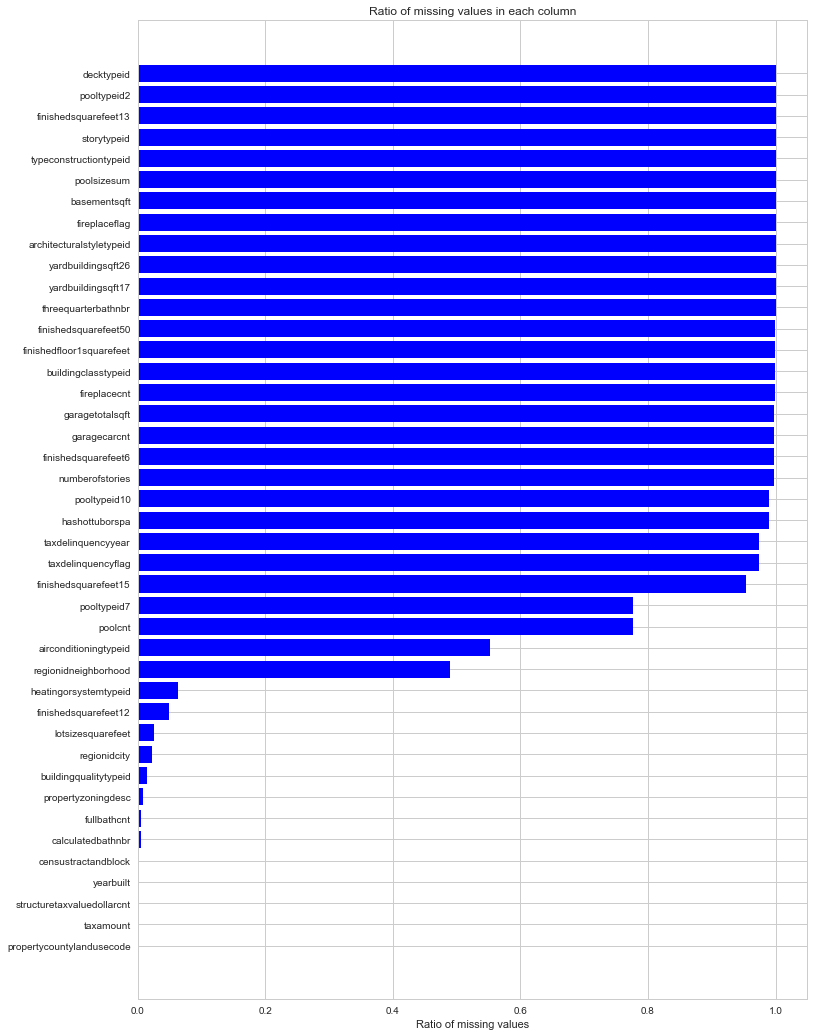

In [31]:
missing_values_df = merged_df.isnull().sum(axis=0).reset_index()
missing_values_df.columns = ['column_name', 'missing_count']
missing_values_df['missing_ratio'] = missing_values_df['missing_count'] / merged_df.shape[0]

missing_values_df = missing_values_df[missing_values_df['missing_count'] > 0]
missing_values_df = missing_values_df.sort_values(by='missing_count')

ind = np.arange(missing_values_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_values_df['missing_ratio'], color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values_df['column_name'], rotation='horizontal')
ax.set_xlabel("Ratio of missing values")
ax.set_title("Ratio of missing values in each column")
plt.show()

#### Remove features with high degree of missing values

In [32]:
removed_columns_df = missing_values_df[missing_values_df['missing_ratio'] > 0.6]
removed_columns = removed_columns_df[removed_columns_df.columns[0]].tolist()

good_features_df = merged_df.drop(removed_columns, axis=1)

print("Removed Features")
removed_columns

Removed Features


['poolcnt',
 'pooltypeid7',
 'finishedsquarefeet15',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'hashottuborspa',
 'pooltypeid10',
 'numberofstories',
 'finishedsquarefeet6',
 'garagecarcnt',
 'garagetotalsqft',
 'fireplacecnt',
 'buildingclasstypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet50',
 'threequarterbathnbr',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'architecturalstyletypeid',
 'fireplaceflag',
 'basementsqft',
 'poolsizesum',
 'typeconstructiontypeid',
 'storytypeid',
 'finishedsquarefeet13',
 'pooltypeid2',
 'decktypeid']

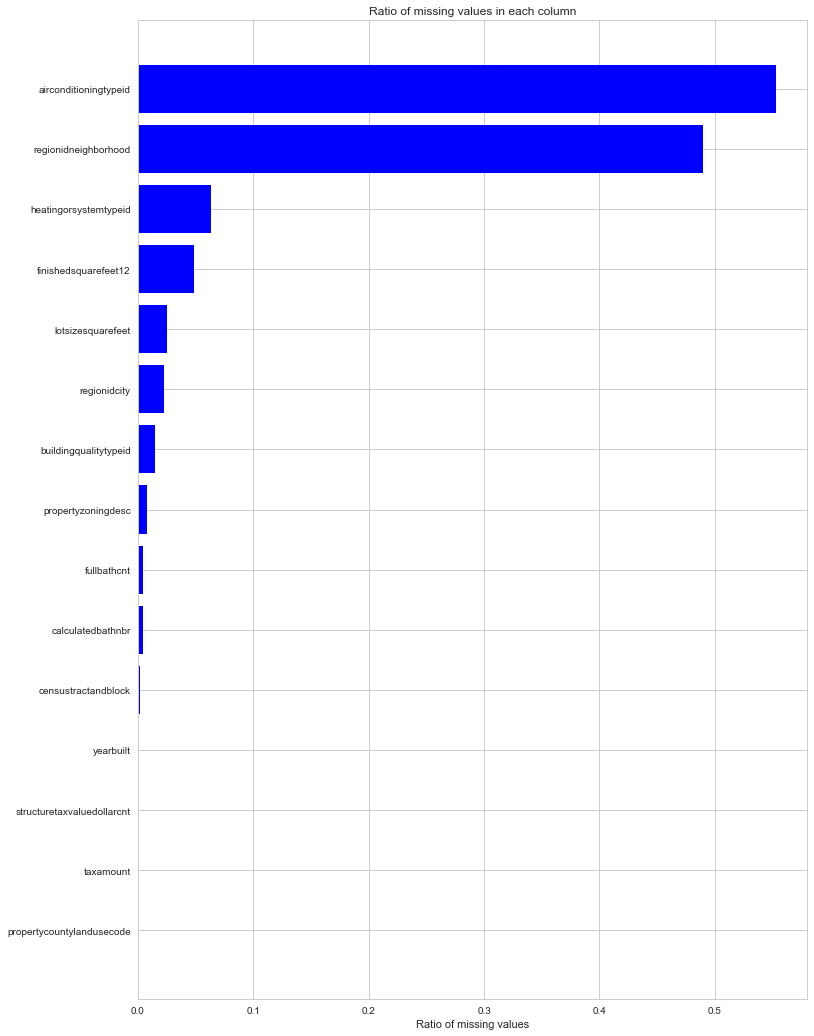

In [33]:
missing_values_df = good_features_df.isnull().sum(axis=0).reset_index()
missing_values_df.columns = ['column_name', 'missing_count']
missing_values_df['missing_ratio'] = missing_values_df['missing_count'] / merged_df.shape[0]

missing_values_df = missing_values_df[missing_values_df['missing_count'] > 0]
missing_values_df = missing_values_df.sort_values(by='missing_count')

ind = np.arange(missing_values_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_values_df['missing_ratio'], color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values_df['column_name'], rotation='horizontal')
ax.set_xlabel("Ratio of missing values")
ax.set_title("Ratio of missing values in each column")
plt.show()

#### Inspect manually -with data dictionary and domain knowledge - and confirm one by one if variable is to be discarded for high degree of missing values or they can be salvaged

In [34]:
#taxdelinquencyflag may be important, will fill it with "False" if it is not true
#'garage' and 'garage' features may be important for US and they are 0 if data is not filled in

merged_df['taxdelinquencyflag'] = merged_df['taxdelinquencyflag'].apply(lambda x: 1 if x == "Y" else 0)
merged_df['garagecarcnt'] = merged_df['garagecarcnt'].fillna(0)  #important to US people
merged_df['garagetotalsqft'] = merged_df['garagetotalsqft'].fillna(0) #important to US people

removed_columns = ['regionidneighborhood',
 'airconditioningtypeid',
 'numberofstories',
 'poolcnt',
 'pooltypeid7',
 'threequarterbathnbr',
 'fireplacecnt',
 'finishedsquarefeet50',
 'finishedfloor1squarefeet',
 'finishedsquarefeet15',
 'yardbuildingsqft17',
 'hashottuborspa',
 'taxdelinquencyyear',
 'pooltypeid2',
 'pooltypeid10',
 'poolsizesum',
 'decktypeid',
 'finishedsquarefeet6',
 'typeconstructiontypeid',
 'architecturalstyletypeid',
 'fireplaceflag',
 'yardbuildingsqft26',
 'storytypeid',
 'basementsqft',
 'finishedsquarefeet13',
 'buildingclasstypeid'
]

good_features_df = merged_df.drop(removed_columns, axis=1)

print("Removed features due to high degree of missing data and after manual inspection")
removed_columns

Removed features due to high degree of missing data and after manual inspection


['regionidneighborhood',
 'airconditioningtypeid',
 'numberofstories',
 'poolcnt',
 'pooltypeid7',
 'threequarterbathnbr',
 'fireplacecnt',
 'finishedsquarefeet50',
 'finishedfloor1squarefeet',
 'finishedsquarefeet15',
 'yardbuildingsqft17',
 'hashottuborspa',
 'taxdelinquencyyear',
 'pooltypeid2',
 'pooltypeid10',
 'poolsizesum',
 'decktypeid',
 'finishedsquarefeet6',
 'typeconstructiontypeid',
 'architecturalstyletypeid',
 'fireplaceflag',
 'yardbuildingsqft26',
 'storytypeid',
 'basementsqft',
 'finishedsquarefeet13',
 'buildingclasstypeid']

#### Filter out Correlated Features for inspection (Not needed anymore since we remove manually)

In [35]:
def remove_correlation(input_dataset, threshold):
    dataset = input_dataset.copy(deep=True)
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                colname_j = corr_matrix.columns[j] # getting the name of the other column
                col_corr.add(colname)
                if colname in dataset.columns:
                    print("Remove '{}' due to it's similarity to '{}'".format(colname, colname_j))
                    del dataset[colname] # deleting the column from the dataset

    return dataset, col_corr

#### Inspect correlated Features manually and remove thems

In [36]:
# Remove 'num_bathroom' instead of 'calculatedbathnbr' as Zillow clarified that they used 'calculatedbathnbr' for their Zillow Est.
# Remove 'finishedsquarefeet12' due to it's similarity to 'calculatedfinishedsquarefeet' This is ok!! area_live_finished which is calculatedfinishedsquarefeet has more complete data!
# Remove 'fullbathcnt' due to it's similarity to 'bathroomcnt' --> Looks ok, the bathroomcnt have more data
# Remove 'rawcensustractandblock' due to it's similarity to 'fips'
# Remove 'landtaxvaluedollarcnt' due to it's similarity to 'taxvaluedollarcnt' --> Looks ok, Taxvaluedollarcnt has more infomration
# Remove 'taxamount' due to it's similarity to 'taxvaluedollarcnt'
# Remove 'censustractandblock' due to it's similarity to 'fips' 

removed_columns =[
    'bathroomcnt',
    'censustractandblock',
    'finishedsquarefeet12',
    'fullbathcnt',
    'landtaxvaluedollarcnt',
    'rawcensustractandblock',
    'taxamount'
]

good_features_df = good_features_df.drop(removed_columns, axis=1)

#### Further Feature Inspection

In [37]:
removed_columns = [
    "parcelid", #Removed Unique Ident
    "transactiondate", # Not vital for current problem
    "propertycountylandusecode", #1 hot encoded land use have more detailed information
    "propertyzoningdesc",  #1 hot encoded land use have more detailed information
    "fips", #the 1-hot encoded postal code has better information
    "assessmentyear", # same information  #### LOOK AT it after new plots!
]

good_features_df = good_features_df.drop(removed_columns, axis=1)

## Construct Data

### Impute several missing value (N/A) with zero (0) or special value if applicable

In [38]:
good_features_df['heatingorsystemtypeid'] = good_features_df['heatingorsystemtypeid'].fillna(13)  #Fill as 13 which is "None" category in data_dictu

### Impute the rest of missing value (N/A) with Mean value

In [39]:
good_features_df = good_features_df.fillna(good_features_df.mean())

In [40]:
def train_validate_test_split(features, target, validate_size, test_size):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = (validate_size + test_size))
    x_validate, x_test, y_validate, y_test = train_test_split(x_test, y_test, test_size = test_size / (validate_size + test_size))
    return x_train, x_validate, x_test, y_train, y_validate, y_test

In [41]:
def dataframe_split(dataframe, target_column, as_matrix=True):
    target = dataframe[target_column]
    features = dataframe.loc[:, dataframe.columns != target_column]
    if as_matrix:
        target = target.as_matrix()
        features = features.as_matrix()
    return features, target

## Feature Importance Scores based on XGBoost

In [42]:
environment.reproducible()

target_column = 'logerror'

xgb_df = good_features_df.drop(['abs_logerror'], axis=1)

features, target = dataframe_split(xgb_df, target_column, as_matrix=False)

x_train, x_test, y_train, y_test = train_test_split(
    features,
    target.reshape((-1, 1)),
    test_size=0.3,
)

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


In [43]:
import xgboost as xgb

y_mean = np.mean(y_train)

xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

num_boost_rounds = 250

# train model
xgb_model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)

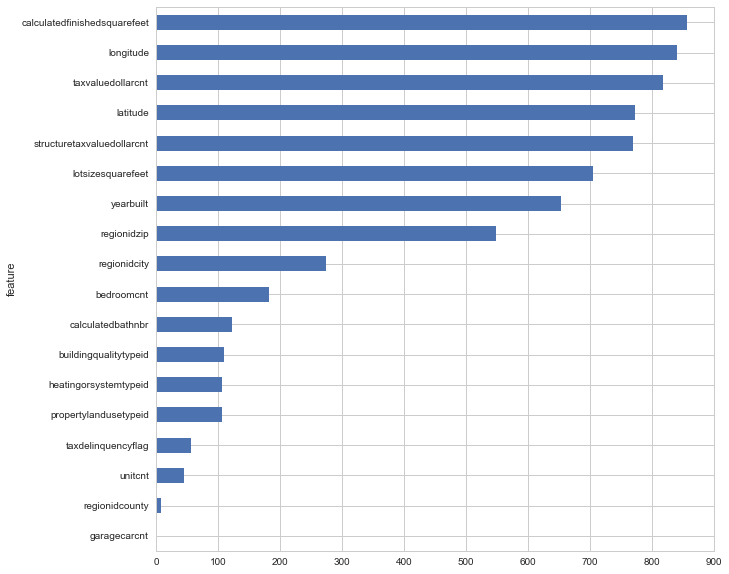

In [44]:
importance = xgb_model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])

# Plot Feature Importance
plt.figure()
importance_df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 10))

## Integrate Data

In [45]:
environment.reproducible()

target_column = "logerror"

dropped_columns = [ 
    "regionidzip",
    "propertylandusetypeid", 
    "abs_logerror"
]

final_df = good_features_df.drop(dropped_columns, axis=1) #all dropping done at feature engineering section, 
features, target = dataframe_split(final_df, target_column)

x_train, x_validate, x_test, y_train, y_validate, y_test = train_validate_test_split(
    preprocessing.minmax_scale(features),
    preprocessing.minmax_scale(target.reshape((-1, 1))),
    validate_size=0.15, 
    test_size=0.15,
)

num_features = x_train.shape[1]
num_target = y_train.shape[1]

# Modeling

## GRNN

In [46]:
grnn_model = algorithms.GRNN(std=0.7, verbose=True)
grnn_model.train(x_train, y_train)

with open('grnn.pickle', 'wb') as f:
    pickle.dump(grnn_model, f)


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.7



### Evaluate GRNN

In [47]:
y_predicted = grnn_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10840361788337305
Mean Absolute Error (0=Best, 1=Worst): 0.06981442420090023
Median Absolute Error (0=Best, 1=Worst): 0.0415848706317975


### GRNN Residual Plot

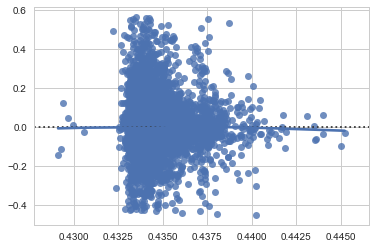

In [48]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

There is no pattern on the residual plot, that means our model decently predict the target class, since,

1. they’re pretty symmetrically distributed, tending to cluster towards the middle of the plot
2. they’re clustered around the lower single digits of the y-axis (e.g., -0.4 and 0.6, not 30 or 150)
3. in general there aren’t clear patterns

### Train GRNN model with important features based on XG Boosting

In [49]:
df = importance_df[importance_df['fscore'] > 120]

target_column = "logerror"
important_features = df['feature'].tolist()
important_features.append(target_column)

important_features_df = final_df.filter(items=important_features)

important_features_df.head(5)

,calculatedbathnbr,bedroomcnt,regionidcity,yearbuilt,lotsizesquarefeet,structuretaxvaluedollarcnt,latitude,taxvaluedollarcnt,longitude,calculatedfinishedsquarefeet,logerror
0,2.0,3.0,12447.0,1959.0,7528.0,122754.0,34280990.0,360170.0,-118488536.0,1684.0,0.0276
2,3.0,2.0,47019.0,1940.0,11423.0,61994.0,34136312.0,119906.0,-118175032.0,2217.0,-0.0040
3,2.0,2.0,12447.0,1987.0,70859.0,171518.0,33755800.0,244880.0,-118309000.0,839.0,0.0218
5,4.0,4.0,29712.0,1982.0,2708.0,880650.0,33870089.0,2447951.0,-118402768.0,3067.0,-0.2705
6,1.0,2.0,24174.0,1939.0,6677.0,64549.0,33899475.0,111521.0,-118212720.0,1297.0,0.0440


In [50]:
features, target = dataframe_split(important_features_df, target_column)

xg_x_train, xg_x_validate, xg_x_test, xg_y_train, xg_y_validate, xg_y_test = train_validate_test_split(
    preprocessing.minmax_scale(features),
    preprocessing.minmax_scale(target.reshape((-1, 1))),
    validate_size=0.15, 
    test_size=0.15,
)

num_features = xg_x_train.shape[1]
num_target = xg_y_train.shape[1]

### Test Neupy GRNN on our dataset
grnn_model = algorithms.GRNN(std=0.7, verbose=True)
grnn_model.train(xg_x_train, xg_y_train)


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.7



### Evaluate GRNN with important features

In [51]:
xg_y_predicted = grnn_model.predict(xg_x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(xg_y_test, xg_y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(xg_y_test, xg_y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(xg_y_test, xg_y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10871357535557445
Mean Absolute Error (0=Best, 1=Worst): 0.07084980993053998
Median Absolute Error (0=Best, 1=Worst): 0.042398119591272765


### GRNN Residual Plot

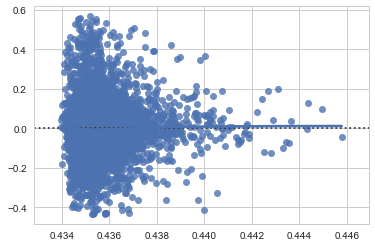

In [52]:
sns.residplot(xg_y_predicted.ravel(), xg_y_test.ravel(), lowess=True)

### Grid search for GRNN's std parameters

In [74]:
params = np.linspace(0.1, 0.9, 9)

best_rmse = 1
best_std = 0

for std in params:
    grnn = algorithms.GRNN(std=std, verbose=True)
    grnn.train(x_train, y_train)
    
    y_predicted = grnn.predict(x_test)
    rmse = estimators.rmse(y_predicted, y_test)
    print("RMSE {} for std {}".format(rmse, std))
    if rmse < best_rmse:
        best_rmse = rmse
        best_std = std
        
        with open('grnn.pickle', 'wb') as f:
            pickle.dump(grnn, f)

print("Best std = {} with RMSE = {}".format(best_std, best_rmse))


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.1

RMSE 0.11009284557322441 for std 0.1

Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.2

RMSE 0.10817836419185 for std 0.2

Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.30000000000000004

RMSE 0.10790340549645062 for std 0.30000000000000004

Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = N

### Load saved GRNN model

In [75]:
with open('grnn.pickle', 'rb') as f:
    grnn_model = pickle.load(f)
    
    y_predicted = grnn_model.predict(x_test)

    print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
    print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
    print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10782494842874617
Mean Absolute Error (0=Best, 1=Worst): 0.07018153114824931
Median Absolute Error (0=Best, 1=Worst): 0.04250615254196685


In [55]:
df_test = pd.DataFrame(np.concatenate((y_test, y_predicted), axis=1), columns={'actual_logerror', 'predicted_logerror'})
df_test.to_csv('grnn_prediction_result_best.csv', sep=',', encoding='utf-8', index=False)

## Radial Basis Function Network

In [56]:
features, target = dataframe_split(final_df, target_column)

x_train, x_validate, x_test, y_train, y_validate, y_test = train_validate_test_split(
    preprocessing.minmax_scale(features),
    preprocessing.minmax_scale(target.reshape((-1, 1))),
    validate_size=0.15, 
    test_size=0.15,
)

num_features = x_train.shape[1]
num_target = y_train.shape[1]

rbfn_model = RBFN(input_shape = num_features, hidden_shape = num_features)
rbfn_model.train(x_train,y_train)

with open('rbfn.pickle', 'wb') as f:
    pickle.dump(rbfn_model, f)

### Evaluate the model

In [57]:
y_predicted = rbfn_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.13104524682696841
Mean Absolute Error (0=Best, 1=Worst): 0.0878044756492499
Median Absolute Error (0=Best, 1=Worst): 0.05541287503508313


### Residual Plot

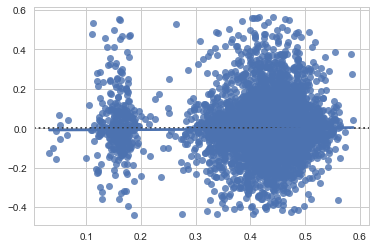

In [58]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

## Conjugate Gradient Neural Network


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 2.43 seconds

Start training

[TRAINING DATA] shapes: (39221, 18)
[TEST DATA] shapes: (8405, 18)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.011914 |    0.011756 |      907 ms |
|          25 |    0.011827 |    0.011678 |      817 ms |
|          50 |    0.011823 |    0.011681 |       1 sec |
|          75 |    0.011821 

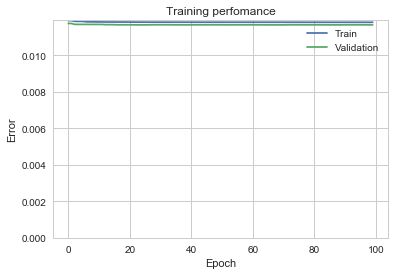

In [59]:
cgnet_model = algorithms.ConjugateGradient(
    connection=[
        layers.Input(num_features),
        layers.Sigmoid(50),
        layers.Sigmoid(num_target),
    ],
    search_method='golden',
    show_epoch=25,
    verbose=True,
    addons=[algorithms.LinearSearch],
)

cgnet_model.train(x_train, y_train, x_validate, y_validate, epochs=100)

plots.error_plot(cgnet_model)

with open('cgnet.pickle', 'wb') as f:
    pickle.dump(cgnet_model, f)

In [60]:
y_predicted = cgnet_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.1090010861119215
Mean Absolute Error (0=Best, 1=Worst): 0.0714499134529646
Median Absolute Error (0=Best, 1=Worst): 0.04298918994882778


### Residual Plot

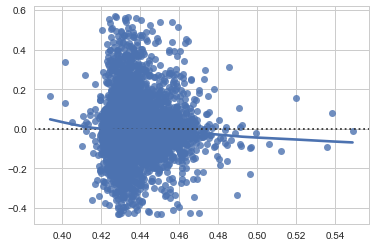

In [61]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

## Gradient Descent Network

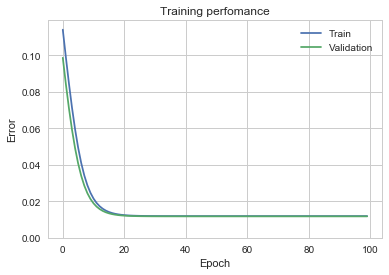

In [62]:
class Exponential(init.Initializer):
    def __init__(self, scale=0.01):
        self.scale = scale

    def sample(self, shape):
        return np.random.exponential(self.scale, size=shape)
    
gdnet_model = algorithms.GradientDescent(
    [
        layers.Input(num_features),
        layers.Sigmoid(num_features * 2, weight=Exponential(scale=0.02)),
        layers.Sigmoid(num_target, weight=Exponential(scale=0.05)),
    ]
)

gdnet_model.train(x_train, y_train, x_validate, y_validate, epochs=100)

plots.error_plot(gdnet_model)

with open('gdnet.pickle', 'wb') as f:
    pickle.dump(gdnet_model, f)

In [63]:
y_predicted = gdnet_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10938871994717751
Mean Absolute Error (0=Best, 1=Worst): 0.07162826696296233
Median Absolute Error (0=Best, 1=Worst): 0.04304548399591768


### Residual Plot

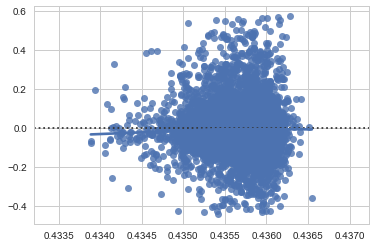

In [64]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

## Ensembled Model using average method

In [65]:
f = open('grnn.pickle', 'rb')
grnn_model = pickle.load(f)

f = open('rbfn.pickle', 'rb')
rbfn_model = pickle.load(f)

f = open('cgnet.pickle', 'rb')
cgnet_model = pickle.load(f)

f = open('gdnet.pickle', 'rb')
gdnet_model = pickle.load(f)


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.31 seconds


In [66]:
# ensemble = AveragedNetwork([grnn_model, rbfn_model, cgnet_model, gdnet_model])
ensemble = AveragedNetwork([grnn_model, cgnet_model, gdnet_model])

y_ensemble_predicted = ensemble.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_ensemble_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_ensemble_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_ensemble_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10910299460365049
Mean Absolute Error (0=Best, 1=Worst): 0.07140862441563695
Median Absolute Error (0=Best, 1=Worst): 0.04292888383843402


In [67]:
with open('ensembled_network.pickle', 'wb') as f:
    pickle.dump(ensemble, f)

### Residual Plot

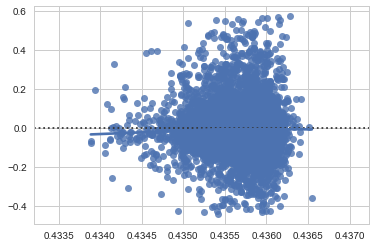

In [68]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

## Ensembled Model using Stacking

In [69]:
f = open('grnn.pickle', 'rb')
grnn_model = pickle.load(f)

f = open('rbfn.pickle', 'rb')
rbfn_model = pickle.load(f)

f = open('cgnet.pickle', 'rb')
cgnet_model = pickle.load(f)

f = open('gdnet.pickle', 'rb')
gdnet_model = pickle.load(f)


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.30 seconds


In [70]:
features, target = dataframe_split(final_df, target_column)

x_train, x_test, y_train, y_test = train_test_split(
    preprocessing.minmax_scale(features),
    preprocessing.minmax_scale(target.reshape((-1, 1))),
    test_size=0.3,
)

num_features = x_train.shape[1]
num_target = y_train.shape[1]

ensemble = StackedNetwork([grnn_model, cgnet_model, gdnet_model])

ensemble.train(x_train, y_train, pre_train = True)

y_ensemble_predicted = ensemble.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_ensemble_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_ensemble_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_ensemble_predicted)))

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Root Mean Square Error (0=Best, 1=Worst): 0.10821574838417215
Mean Absolute Error (0=Best, 1=Worst): 0.07109614108994171
Median Absolute Error (0=Best, 1=Worst): 0.04332891544058795


In [71]:
with open('ensembled_stacked_network.pickle', 'wb') as f:
    pickle.dump(ensemble, f)

### Residual Plot

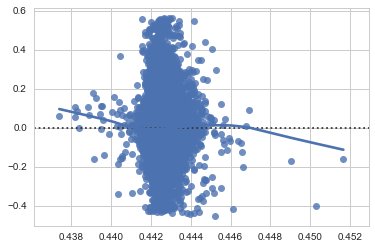

In [72]:
sns.residplot(y_ensemble_predicted.ravel(), y_test.ravel(), lowess=True)